# Twitter Sentiment Analysis

In [18]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
# Keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\khalid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [84]:
# DATASET
DATASET_COLUMNS = ["text","class"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "Depressed"
NEGATIVE = "Non-Depresseed"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.5, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

In [25]:

df = pd.read_csv("Suicide_Detection.csv", encoding =DATASET_ENCODING)

In [9]:
print("Dataset size:", len(df))

Dataset size: 232074


In [32]:
df.head(5)

,text,target
0,Ex Wife Threatening SuicideRecently I left my ...,1
1,Am I weird I don't get affected by compliments...,0
2,Finally 2020 is almost over... So I can never ...,0
3,i need helpjust help me im crying so hard,1
4,"Iâm so lostHello, my name is Adam (16) and I...",1


In [31]:
df=df.drop('Unnamed: 0', axis=1)

In [27]:
df = df.rename(columns = {"class": "target"})

In [28]:
le = preprocessing.LabelEncoder()
df['target'] = le.fit_transform(df.target.values)

### Map target label to String
* **0** -> **Non-Suicide**
* **1** -> **Suicide**

In [33]:
decode_map = {0: 'Non-Suicide', 1: 'Suicide'}
def decode_sentiment(label):
    return decode_map[int(label)]

In [34]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: total: 46.9 ms
Wall time: 45.4 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

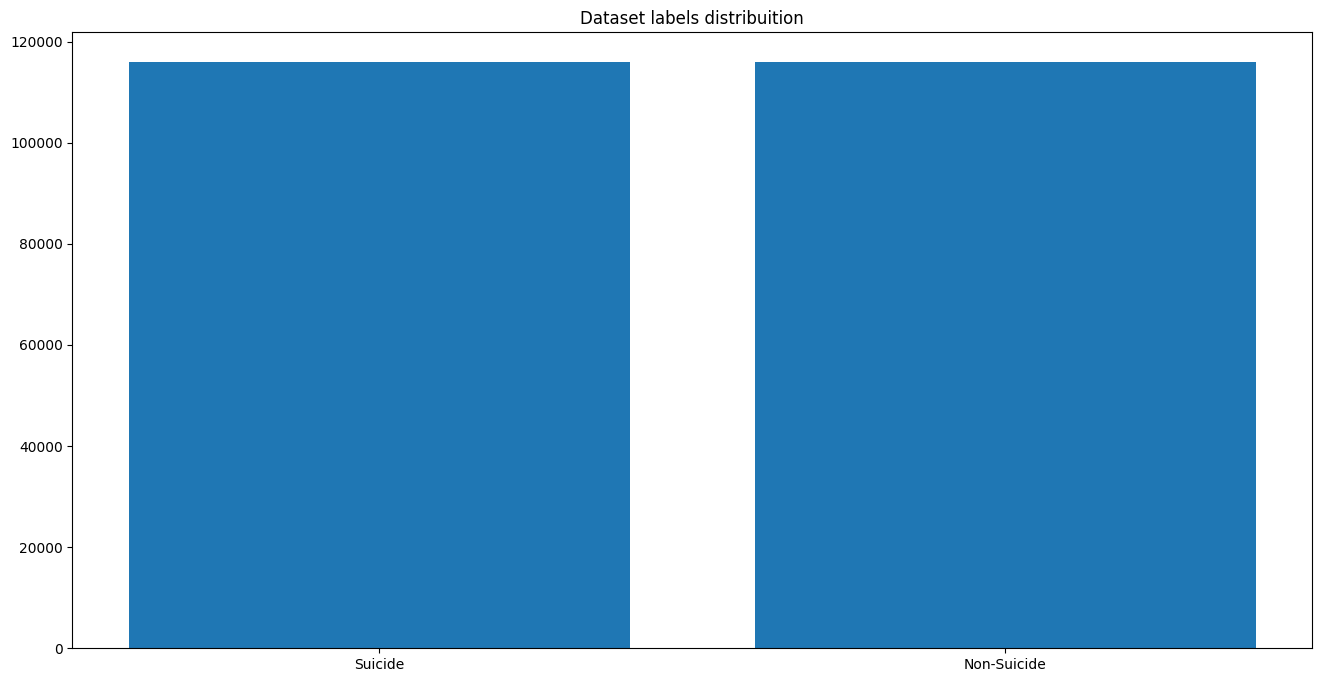

In [35]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [36]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [37]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [38]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: total: 58 s
Wall time: 1min


### Split train and test

In [39]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 185659
TEST size: 46415


### Word2Vec 

In [40]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: total: 1.23 s
Wall time: 1.32 s


In [41]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [42]:
w2v_model.build_vocab(documents)

2022-12-04 01:41:05,267 : INFO : collecting all words and their counts
2022-12-04 01:41:05,269 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-12-04 01:41:05,379 : INFO : PROGRESS: at sentence #10000, processed 618896 words, keeping 28321 word types
2022-12-04 01:41:05,493 : INFO : PROGRESS: at sentence #20000, processed 1225469 words, keeping 39912 word types
2022-12-04 01:41:05,615 : INFO : PROGRESS: at sentence #30000, processed 1849265 words, keeping 53100 word types
2022-12-04 01:41:05,725 : INFO : PROGRESS: at sentence #40000, processed 2443328 words, keeping 60559 word types
2022-12-04 01:41:05,833 : INFO : PROGRESS: at sentence #50000, processed 3051152 words, keeping 68084 word types
2022-12-04 01:41:05,947 : INFO : PROGRESS: at sentence #60000, processed 3682742 words, keeping 76141 word types
2022-12-04 01:41:06,064 : INFO : PROGRESS: at sentence #70000, processed 4293117 words, keeping 81571 word types
2022-12-04 01:41:06,180 : INFO : PROGRES

In [43]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 23022


In [44]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2022-12-04 01:41:23,350 : INFO : training model with 8 workers on 23022 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2022-12-04 01:41:24,372 : INFO : EPOCH 1 - PROGRESS: at 10.79% examples, 1101905 words/s, in_qsize 15, out_qsize 0
2022-12-04 01:41:25,376 : INFO : EPOCH 1 - PROGRESS: at 21.97% examples, 1119721 words/s, in_qsize 14, out_qsize 1
2022-12-04 01:41:26,400 : INFO : EPOCH 1 - PROGRESS: at 33.23% examples, 1127006 words/s, in_qsize 13, out_qsize 2
2022-12-04 01:41:27,416 : INFO : EPOCH 1 - PROGRESS: at 43.76% examples, 1112266 words/s, in_qsize 12, out_qsize 3
2022-12-04 01:41:28,462 : INFO : EPOCH 1 - PROGRESS: at 55.32% examples, 1114101 words/s, in_qsize 14, out_qsize 3
2022-12-04 01:41:29,482 : INFO : EPOCH 1 - PROGRESS: at 65.79% examples, 1106121 words/s, in_qsize 15, out_qsize 0
2022-12-04 01:41:30,510 : INFO : EPOCH 1 - PROGRESS: at 76.95% examples, 1106569 words/s, in_qsize 16, out_qsize 4
2022-12-04 01:41:31,526 : INFO : EPOCH 1 - PR

CPU times: total: 19min 59s
Wall time: 4min 50s


(328063936, 361642368)

In [45]:
w2v_model.most_similar("love")

C:\Users\khalid\AppData\Local\Temp\ipykernel_22292\2564826958.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  w2v_model.most_similar("love")
2022-12-04 01:46:33,300 : INFO : precomputing L2-norms of word weight vectors


[('loved', 0.6858488917350769),
 ('loves', 0.6481505632400513),
 ('loving', 0.5441411137580872),
 ('truly', 0.48289811611175537),
 ('adore', 0.4756086766719818),
 ('amazing', 0.4605231285095215),
 ('soulmate', 0.46051526069641113),
 ('unconditionally', 0.4594517648220062),
 ('wonderful', 0.45159879326820374),
 ('cared', 0.4437047839164734)]

### Tokenize Text

In [49]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 133682
CPU times: total: 8.17 s
Wall time: 8.77 s


In [50]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: total: 7.45 s
Wall time: 7.88 s


### Label Encoder 

In [56]:
labels = df_train.target.unique().tolist()
labels

['Suicide', 'Non-Suicide']

In [57]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (185659, 1)
y_test (46415, 1)


In [58]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (185659, 300)
y_train (185659, 1)

x_test (46415, 300)
y_test (46415, 1)


In [59]:
y_train[:10]

array([[1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1]])

In [60]:
y_train

array([[1],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

### Embedding layer

In [61]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(133682, 300)


In [62]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [63]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          40104600  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,265,101
Trainable params: 160,501
Non-trainable params: 40,104,600
_________________________________________________________________


### Compile model

In [64]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [65]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [66]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
164/164 [==============================] - ETA: 0s - loss: 0.2926 - accuracy: 0.8808 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-12-04 02:34:00,081 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


164/164 [==============================] - 2073s 13s/step - loss: 0.2926 - accuracy: 0.8808 - val_loss: 0.2278 - val_accuracy: 0.9290 - lr: 0.0010
Epoch 2/8
164/164 [==============================] - ETA: 0s - loss: 0.2122 - accuracy: 0.9217 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-12-04 03:16:40,196 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


164/164 [==============================] - 2560s 16s/step - loss: 0.2122 - accuracy: 0.9217 - val_loss: 0.2174 - val_accuracy: 0.9282 - lr: 0.0010
Epoch 3/8
164/164 [==============================] - ETA: 0s - loss: 0.1951 - accuracy: 0.9267 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-12-04 04:03:49,105 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


164/164 [==============================] - 2829s 17s/step - loss: 0.1951 - accuracy: 0.9267 - val_loss: 0.2123 - val_accuracy: 0.9295 - lr: 0.0010
Epoch 4/8
164/164 [==============================] - ETA: 0s - loss: 0.1853 - accuracy: 0.9306 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-12-04 04:53:23,631 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


164/164 [==============================] - 2975s 18s/step - loss: 0.1853 - accuracy: 0.9306 - val_loss: 0.1977 - val_accuracy: 0.9319 - lr: 0.0010
Epoch 5/8
164/164 [==============================] - ETA: 0s - loss: 0.1879 - accuracy: 0.9296 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-12-04 05:44:29,650 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


164/164 [==============================] - 3066s 19s/step - loss: 0.1879 - accuracy: 0.9296 - val_loss: 0.1865 - val_accuracy: 0.9346 - lr: 0.0010
Epoch 6/8
164/164 [==============================] - ETA: 0s - loss: 0.1795 - accuracy: 0.9320 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-12-04 06:36:08,294 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


164/164 [==============================] - 3099s 19s/step - loss: 0.1795 - accuracy: 0.9320 - val_loss: 0.1880 - val_accuracy: 0.9346 - lr: 0.0010
Epoch 7/8
164/164 [==============================] - ETA: 0s - loss: 0.1736 - accuracy: 0.9341 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-12-04 07:27:50,370 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


164/164 [==============================] - 3102s 19s/step - loss: 0.1736 - accuracy: 0.9341 - val_loss: 0.1810 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 8/8
164/164 [==============================] - ETA: 0s - loss: 0.1735 - accuracy: 0.9346 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-12-04 08:19:38,649 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


164/164 [==============================] - 3108s 19s/step - loss: 0.1735 - accuracy: 0.9346 - val_loss: 0.1829 - val_accuracy: 0.9366 - lr: 0.0010
CPU times: total: 14h 58min 21s
Wall time: 6h 20min 11s


### Evaluate

In [67]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

46/46 [==============================] - 49s 1s/step - loss: 0.1861 - accuracy: 0.9365

ACCURACY: 0.9365291595458984
LOSS: 0.1860819011926651
CPU times: total: 3min 4s
Wall time: 49 s


In [68]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

KeyError: 'acc'

### Predict

In [131]:
def decode_sentiment(score, include_neutral=False):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [130]:
def predict(text, include_neutral=False):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [188]:
predict("I am happy very happy kinda want to die though and kill my self")

1/1 [==============================] - 0s 47ms/step


{'label': 'Depressed',
 'score': 0.9318109154701233,
 'elapsed_time': 0.08743023872375488}

In [189]:
predict("my wife divorced me I think I will kill myself today")

1/1 [==============================] - 0s 41ms/step


{'label': 'Depressed',
 'score': 0.9039961695671082,
 'elapsed_time': 0.08736371994018555}

In [126]:
predict("i don't know what i'm doing")

1/1 [==============================] - 0s 43ms/step


{'label': 'Non-Depresseed',
 'score': 0.4438076615333557,
 'elapsed_time': 0.07579827308654785}

### Confusion Matrix

In [109]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

6/6 [==============================] - 47s 8s/step
CPU times: total: 3min 24s
Wall time: 47.3 s


In [110]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

C:\Users\khalid\AppData\Local\Temp\ipykernel_22292\106037557.py:9: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


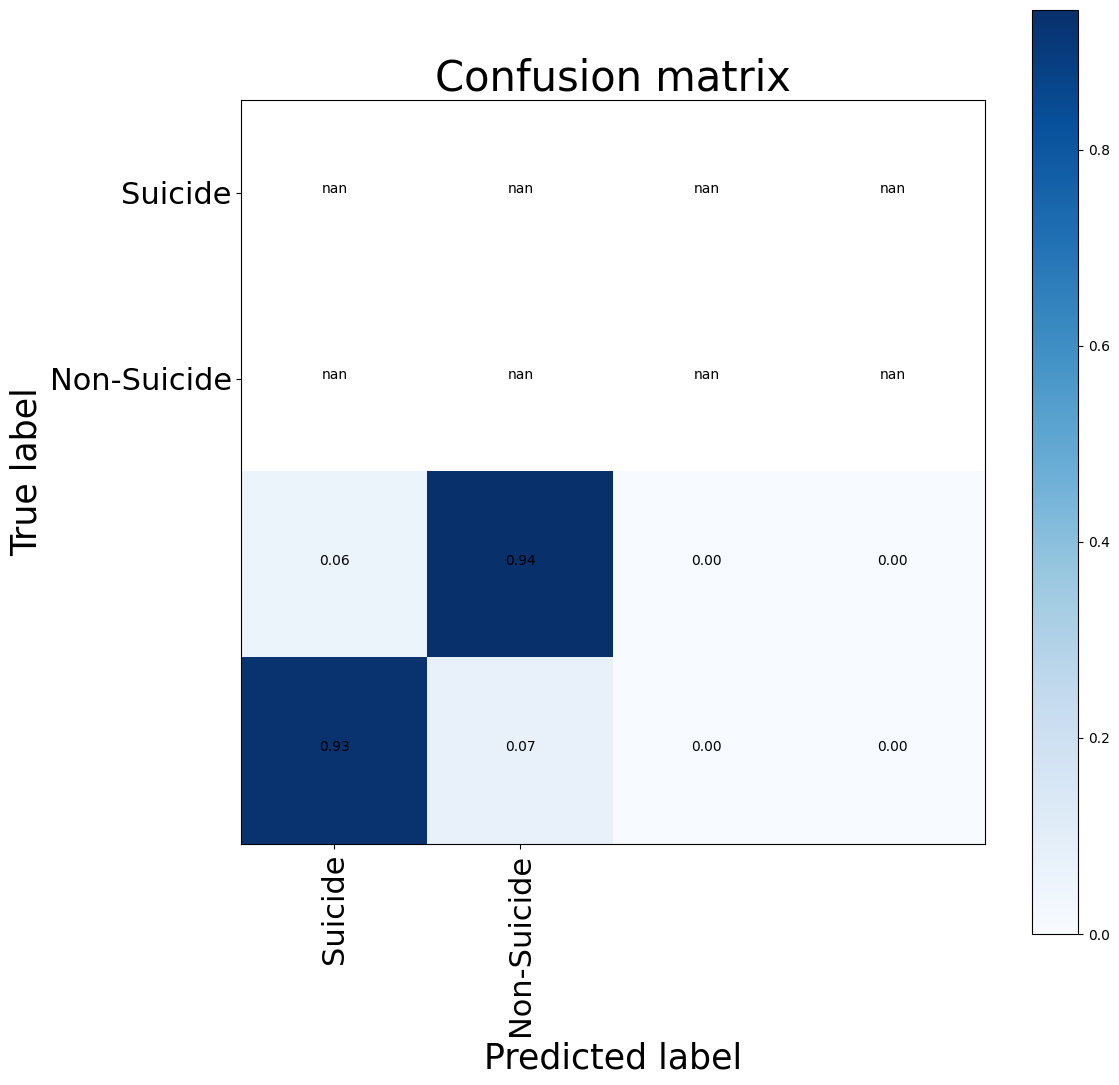

CPU times: total: 469 ms
Wall time: 576 ms


In [111]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [112]:
print(classification_report(y_test_1d, y_pred_1d))

c:\Users\khalid\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\khalid\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

     Depressed       0.00      0.00      0.00       0.0
Non-Depresseed       0.00      0.00      0.00       0.0
   Non-Suicide       0.00      0.00      0.00   23287.0
       Suicide       0.00      0.00      0.00   23128.0

      accuracy                           0.00   46415.0
     macro avg       0.00      0.00      0.00   46415.0
  weighted avg       0.00      0.00      0.00   46415.0



c:\Users\khalid\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\khalid\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\khalid\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

### Accuracy Score

In [113]:
accuracy_score(y_test_1d, y_pred_1d)

0.0

### Save model

In [114]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)

pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2022-12-04 10:05:18,554 : INFO : saving Word2Vec object under model.w2v, separately None
2022-12-04 10:05:18,558 : INFO : not storing attribute vectors_norm
2022-12-04 10:05:18,559 : INFO : not storing attribute cum_table
2022-12-04 10:05:20,915 : INFO : saved model.w2v


In [133]:
pickle.dump(model, open("Sequential.sav", "wb"), protocol=0)
pickle.dump(w2v_model, open("word2vector.pkl", "wb"), protocol=0)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dropout
......vars
...layers\embedding
......vars
.........0
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2022-12-04 10:30:24         2352
metadata.json                                  2022-12-04 10:30:24           64
variables.h5                                   2022-12-04 10:30:26    162368944
